# Model 2: VGG16 model

## 1 Imports

In [1]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import cv2


## 2 Preprocessing the data

Fetching the already split dataset

In [2]:
base_directory = "../../Data/Splitted_Images/"

train_path=base_directory+"/train"
test_path=base_directory+"/test"
val_path=base_directory+"/val"

In [3]:
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        x_val.append(img_arr)

In [4]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [5]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [6]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (170,256),
                                                 batch_size = 128,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (170,256),
                                            batch_size = 128,
                                            class_mode = 'categorical',
                                            shuffle=True)
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (170,256),
                                            batch_size = 128,
                                            class_mode = 'categorical',
                                            shuffle=True)

Found 3500 images belonging to 5 classes.
Found 750 images belonging to 5 classes.
Found 750 images belonging to 5 classes.


In [8]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [9]:
training_set.class_indices


{'bee': 0, 'butterfly': 1, 'cat': 2, 'dog': 3, 'elephant': 4}

In [10]:
train_y.shape,test_y.shape,val_y.shape


((3500,), (750,), (750,))

## 3 Training the model

In [11]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(170, 256, 3))
x = data_augmentation(inputs) 
x = layers.Dropout(0.2)(x)
x = keras.applications.vgg16.preprocess_input(x) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [13]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="models/2_VGG16_Model.h5", save_best_only=True, monitor="val_loss"),
    #EarlyStopping(monitor='val_loss', mode='auto', patience=5)  
    ] 

history = model.fit(
    train_x,
    train_y,
    epochs=150,
    validation_data=(val_x,val_y),
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/150
110/110 [==============================] - 27s 199ms/step - loss: 2.0057 - accuracy: 0.1977 - val_loss: 1.6277 - val_accuracy: 0.2000
Epoch 2/150
110/110 [==============================] - 20s 178ms/step - loss: 1.6322 - accuracy: 0.2094 - val_loss: 1.6194 - val_accuracy: 0.2947
Epoch 3/150
110/110 [==============================] - 21s 187ms/step - loss: 1.5740 - accuracy: 0.2634 - val_loss: 1.5398 - val_accuracy: 0.2907
Epoch 4/150
110/110 [==============================] - 19s 172ms/step - loss: 1.5288 - accuracy: 0.3063 - val_loss: 1.4988 - val_accuracy: 0.3587
Epoch 5/150
110/110 [==============================] - 19s 172ms/step - loss: 1.4964 - accuracy: 0.3380 - val_loss: 1.4952 - val_accuracy: 0.3173
Epoch 6/150
110/110 [==============================] - 19s 172ms/step - loss: 1.4694 - accuracy: 0.3617 - val_loss: 1.4411 - val_accuracy: 0.3640
Epoch 7/150
110/110 [==============================] - 20s 182ms/step - loss: 1.4389 - accuracy: 0.3746 - val_loss: 1.4228 -

## 4 Plotting the training result

In [14]:
def plot_function(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

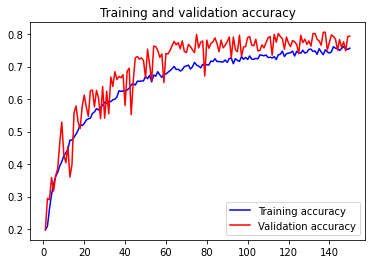

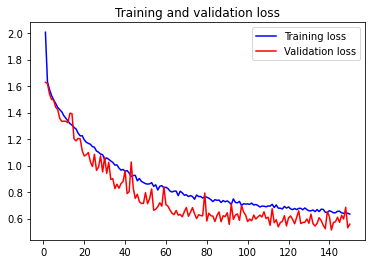

In [15]:
plot_function(history)

## 5 Testing the model on the testset

In [16]:
test_model = keras.models.load_model("models/2_vgg16_model.h5")
test_loss, test_acc = test_model.evaluate(test_x, test_y)
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 4s 150ms/step - loss: 0.5450 - accuracy: 0.7627
Test accuracy: 0.763


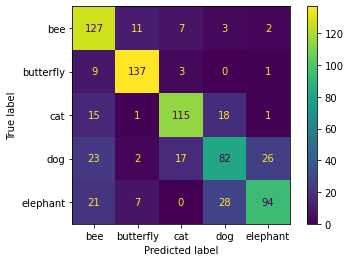

In [17]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = test_model.predict(test_x) 
y_pred = (predictions >= 0.5)

matrix = metrics.confusion_matrix(test_y, y_pred.argmax(axis=1))
cmd = ConfusionMatrixDisplay(matrix, display_labels=['bee','butterfly','cat','dog','elephant'])
cmd.plot()
